# Bayesian Neural Network

### trainig a Neural Network
* **Ordinary Neural Network**
* **Laplace approximation**
* **HMC**
* **HMC + Gibbs sampler**
* **Variational Inference**

## 0. Initialize packages and define functions

In [1]:
#mathematics
using LinearAlgebra
using ForwardDiff
using Optim

#statistics
using Random 
using Statistics
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

In [2]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#initialize the parameter
function init_params(st)
    @unpack  Dx, Dy, D₀ = st
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  Dx, Dy, D₀ = st
    W = reshape(wvec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function nn(x, wvec, st)
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

nn (generic function with 1 method)

## 1. Create data

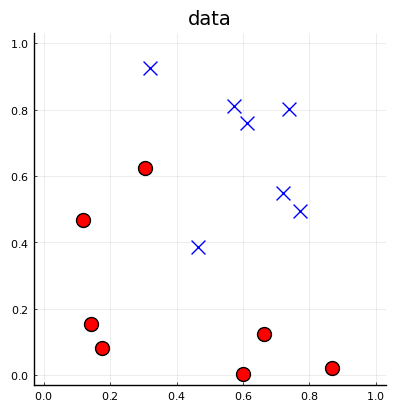

In [3]:
#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(ones(div(N,2)), zeros(div(N,2)))
data = (X=X,Y=Y,N=N)

#plot the data
fig1 = plot_data(X, Y)
savefig(fig1, "figs-BNN/fig1.png")

## 2. Ordinary Neural Network

In [4]:
#loss function 
Ln(y_pred, y_data) = norm(y_pred-y_data)^2

#train the neural network
function train_nn(data, n_train, α, wvec₀, st)
    wvec = wvec₀
    @unpack X,Y,N = data
    @unpack Dx,Dy,D₀ = st
    ∇Ln(wvec, idx, X, Y, st) = ForwardDiff.gradient(wvec->Ln(nn(X[:,idx], wvec, st)[1], Y[idx]), wvec)
    @showprogress for k in 1:n_train
        #choose the sample uniformaly
        idx = rand(1:N)
        
        #gradient descent
        wvec = wvec - α*∇Ln(wvec, idx, X, Y, st)
    end
    return wvec
end

train_nn (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02m


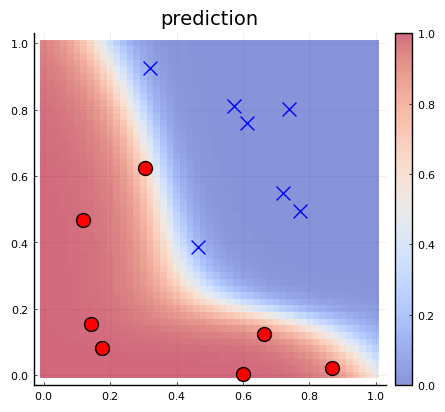

In [5]:
#size
Random.seed!(42)
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)

#initialize NN
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]

#train NN
n_train = Int(1e5)
α = 0.1
wvec = train_nn(data, n_train, α, wvec₀, st)
wvec_nn = wvec

#predict
fig2 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->nn([x1,x2], wvec, st)[1], st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig2 = plot_data(fig2,X,Y)
plot!(title="prediction")
savefig(fig2, "figs-BNN/fig2.png")

## 3. Bayesian Neural Network

In [6]:
#log pdf of prior, model, posterior
logpprior(wvec, λ, dw) = logpdf(MvNormal(zeros(dw),1/sqrt(λ)), wvec)
logpmodel(y, x, wvec, st) = logpdf(Bernoulli(nn(x,wvec,st)[1]), y)
loglik(X, Y, N, wvec, st) = sum([logpmodel(Y[n], X[:,n], wvec, st) for n in 1:N])

function logppost(wvec, data, model_params)
    @unpack X,Y,N = data
    @unpack λw,dw,st = model_params
    return loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw)
end

function logppost(wvec, λw, data, model_params)
    @unpack X,Y,N = data
    @unpack dw,st = model_params
    return loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw)
end

#predictive: returns the probability to new data classified to class 1
function ppred(x, wsamps, st)
    _, n_samps = size(wsamps)
    preds = zeros(n_samps)
    for j in 1:n_samps
        preds[j] = exp(logpmodel(1, x, wsamps[:,j], st))
    end
    return mean(preds)
end

#size
Random.seed!(42)
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)

(Dx = 2, Dy = 1, D₀ = 5)

### 3.1 Laplace approximation

In [7]:
#calculate the MAP estimate of parameters
function calc_MAP(data, model_params, wvec₀)
    opt = Optim.optimize(wvec->-logppost(wvec, data, model_params), wvec₀, BFGS())
    return opt.minimizer
end

#calculate the MAP estimate and Hesse matrix
function calc_params(data, model_params, wvec₀)
    @unpack X,Y,N = data
    @unpack λw,dw,st = model_params
    wMAP = calc_MAP(data, model_params, wvec₀)
    H = ForwardDiff.hessian(wvec->logppost(wvec, data, model_params), wMAP)
    return wMAP, Matrix(Hermitian(H))
end

calc_params (generic function with 1 method)

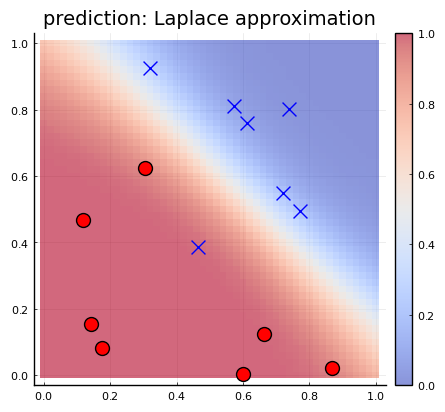

In [8]:
#initialize NN
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 0.1
model_params = (λw=λw, dw=dw, st=st) 

#Laplace approximation
wMAP, H = calc_params(data, model_params, wvec₀)

#calculate and visualize predictive
n_samps = 5000
wsamps = rand(MvNormalCanon(wMAP, -H), n_samps)
fig3 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig3 = plot_data(fig3, X, Y)
plot!(title="prediction: Laplace approximation")
savefig(fig3, "figs-BNN/fig3.png")

### 3.2 Hamiltonian Monte Carlo

In [9]:
#one step of Störmer-Verlet method
function myStörmerVerlet(qvec, pvec, h, f)
    p_mid = pvec + h * f(qvec)/2;
    q_new = qvec + h * p_mid;
    p_new = p_mid + h * f(q_new)/2;
    return q_new, p_new
end

#update the position
function update(T, h, f, qvec, pvec)
    qvec_new = qvec
    pvec_new = pvec
    for t in 1:T
        qvec_new, pvec_new = myStörmerVerlet(qvec_new, pvec_new, h, f)
    end
    return qvec_new, pvec_new
end

#MH acceptance and rejection
function accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
    ΔH = H(xvec, pvec)-H(xvec_old, pvec_old)
    α = min(1.0, exp(-ΔH))
    u = rand()
    if u≤α
        return xvec, pvec
    else
        return xvec_old, pvec_old
    end
end

#Hamiltonian Monte Carlo
function myHMC(data, model_params, wvec₀, n_samps, n_burnin, T, h)
    #initialization
    dw = length(wvec₀)
    wsamps = zeros(dw, n_samps)
    wsamps[:,1] = wvec₀
    wvec = zeros(dw)
    pvec = zeros(dw)
    
    #Hamiltonian and potential
    U(wvec) = -logppost(wvec, data, model_params)
    ∇Uneg(wvec) = -ForwardDiff.gradient(U, wvec)
    H(wvec, pvec) = U(wvec) + norm(pvec)^2/2
    
    #sample
    wvec_old = wvec₀
    pvec_old = randn(dw)
    @showprogress for s in 2:n_samps
        pvec = randn(dw)
        wvec, pvec = update(T, h, ∇Uneg, wvec, pvec)
        wvec, pvec = accept_or_reject(wvec, wvec_old, pvec, pvec_old, H)
        wsamps[:,s] = wvec
        wvec_old = wvec
        pvec_old = pvec
    end
    return wsamps[:,n_burnin:end]
end

myHMC (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


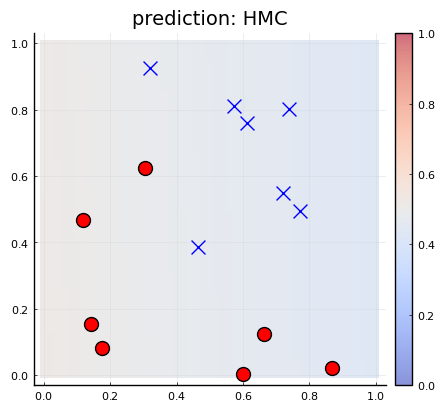

In [10]:
#initialize NN
Random.seed!(42)
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)
λw = 10

#model params
λw = 1
model_params = (λw=λw, dw=dw, st=st) 

#HMC
n_samps = 5000
n_burnin = div(n_samps,10)
T = 100
h = 0.3
wsamps = myHMC(data, model_params, wvec₀, n_samps, n_burnin, T, h)

#calculate and visualize predictive
fig4 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig4 = plot_data(fig4, X, Y)
plot!(title="prediction: HMC")
savefig(fig4, "figs-BNN/fig4.png")

### 3.3 HMC + Gibbs sampler

In [11]:
#Hamiltonian Monte Carlo for hierarchical model
function myHMC_HM(data, model_params, wvec₀, λw₀, n_samps, n_burnin, T, h)
    #initialization
    dw = length(wvec₀)
    wsamps = zeros(dw, n_samps)
    wsamps[:,1] = wvec₀
    λwsamps = zeros(n_samps)
    λwsamps[1] = λw₀
    wvec = zeros(dw)
    pvec = zeros(dw)
    
    #hyperparamters of λw
    @unpack α,β,λw = model_params
    
    #Hamiltonian and potential
    U(wvec, λw) = -logppost(wvec, λw, data, model_params)
    ∇Uneg(wvec, λw) = -ForwardDiff.gradient(wvec->U(wvec, λw), wvec)
    H(wvec, pvec, λw) = U(wvec, λw) + norm(pvec)^2/2
    
    #sample
    wvec_old = wvec₀
    pvec_old = randn(dw)
    @showprogress for s in 2:n_samps
        pvec = randn(dw)
        wvec, pvec = update(T, h, wvec->∇Uneg(wvec, λw), wvec, pvec)
        wvec, pvec = accept_or_reject(wvec, wvec_old, pvec, pvec_old, (wvec, pvec)->H(wvec, pvec, λw))
        wsamps[:,s] = wvec
        λw = rand(Gamma(α+dw/2, 1/(β+norm(wvec)^2/2)))
        λwsamps[s] = λw
        wvec_old = wvec
        pvec_old = pvec
    end
    return wsamps[:,n_burnin:end], λwsamps[n_burnin:end]
end

myHMC_HM (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


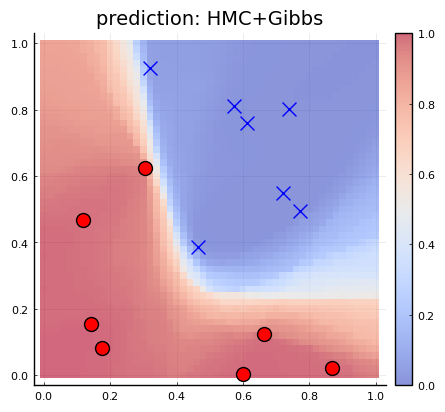

In [12]:
#initialize NN
Random.seed!(42)
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 1
model_params = (λw=λw, dw=dw, st=st, α=1.5, β=1e4)

#HMC+Gibbs sampler
n_samps = 5000
n_burnin = div(n_samps,10)
T = 100
h = 0.1
λw₀ = 1.0
wsamps,λsamps = myHMC_HM(data, model_params, wvec₀, λw₀, n_samps, n_burnin, T, h)
w_post_samps = wsamps

#calculate and visualize predictive
fig5 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig5 = plot_data(fig5, X, Y)
plot!(title="prediction: HMC+Gibbs")
savefig(fig5, "figs-BNN/fig5.png")

### 3.4-1 Variational Inference - score function estimation

In [13]:
#∇θLn(θ)
function ∇θLn(x, y, N, wsamps, θvec, λw, st)
    dw,S = size(wsamps)
    centwvec = wsamps-θvec[1:dw]*ones(S)'
    logpmodels = zeros(S)
    for s in 1:S
        logpmodels[s] = logpmodel(y, x, wsamps[:,s], st)
    end
    arr1 = centwvec .* (ones(dw)*logpmodels')
    arr2 = centwvec .* arr1
    ∇θLnvec = zeros(2*dw)
    for j in 1:dw
        ∇θLnvec[j] = N*exp(-2*θvec[dw+j])*mean(arr1[j,:])-λw*θvec[j]
        ∇θLnvec[dw+j] = N*exp(-2*θvec[dw+j])*mean(arr2[j,:])-N*mean(logpmodels)+1-λw*exp(2*θvec[dw+j])
    end
    return ∇θLnvec
end

#calculate ELBO
function ELBO(X, Y, N, wsamps, θvec, λw, st)
    dw,S = size(wsamps)
    logpmodels = zeros(S)
    for s in 1:S
        for n in 1:N
            logpmodels[s] += logpmodel(Y[n], X[:,n], wsamps[:,s], st)
        end
    end
    return mean(logpmodels)-λw*sum(θvec[1:dw].^2)/2-λw*sum(exp.(2*θvec[dw+1:end]))/2+sum(θvec[dw+1:end])+dw/2+dw*log(λw)/2
end

#sample from approximation distribution r
post_samps(θvec, n_samps, dw) = rand(MvNormal(θvec[1:dw], exp.(θvec[dw+1:2*dw])), n_samps)

#variational inference
function myVI(data, model_params, α, n_train, tol)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    θvec = vcat(zeros(dw), ones(dw))
    n_samps = 5000
    wsamps = zeros(dw, n_samps)
    history = zeros(n_train)
    @showprogress for k in 2:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[idx]
        wsamps = post_samps(θvec, n_samps, dw)
        θvec = θvec + α*∇θLn(x, y, N, wsamps, θvec, λw, st)/k
        history[k] = ELBO(X, Y, N, wsamps, θvec, λw, st)
        if abs(history[k]-history[k-1])<tol
            return θvec, history[2:k]
        end
    end
    return θvec, history
end

myVI (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:07


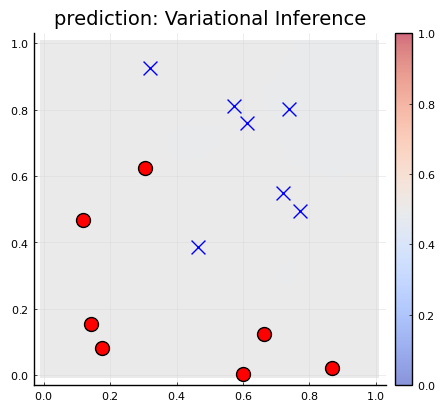

In [14]:
#initialize NN
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 1e-3
model_params = (λw=λw, dw=dw, st=st)

#calculate the variational parameters
α = 0.3
tol = 1e-6
n_train = 3000
θvec, history = myVI(data, model_params, α, n_train, tol)

#posterior sample
n_samps = 5000
wsamps = post_samps(θvec, n_samps, dw)

#calculate and visualize predictive
fig6 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig6 = plot_data(fig6, X, Y)
plot!(title="prediction: Variational Inference")
savefig(fig6, "figs-BNN/fig6.png")

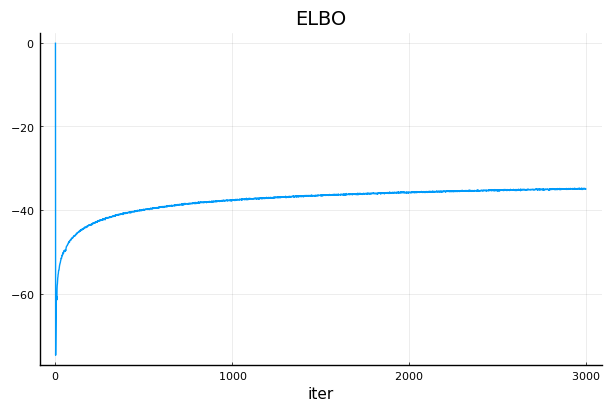

In [15]:
fig7 = plot(1:n_train, history, xlabel="iter", title="ELBO", label=false)
savefig(fig7, "figs-BNN/fig7.png")

### 3.4-2 Variational Inference - reparameterization trick

In [16]:
#reparameterization
g(θvec, ϵvec) = θvec[1:dw] + exp.(θvec[dw+1:end]) .* ϵvec
∇θlogpmodel(y,x,θvec,ϵvec,st) = ForwardDiff.gradient(θvec->logpmodel(y, x, g(θvec, ϵvec), st), θvec)

#∇θLn(θ)
function ∇θLn(x, y, N, ϵsamps, θvec, λw, st)
    dw,S = size(ϵsamps)
    ∇θLnvecs = zeros(2*dw, S)
    for s in 1:S
        ∇θLnvecs[:,s] = ∇θlogpmodel(y,x,θvec,ϵsamps[:,s],st)
    end
    ∇θLnvec = N * mean(∇θLnvecs, dims=2)
    for j in 1:dw
        ∇θLnvec[j] += -λw*θvec[j]
        ∇θLnvec[dw+j] += 1-λw*exp(2*θvec[dw+j])
    end
    return ∇θLnvec
end

#calculate ELBO
function ELBO(X, Y, N, wsamps, θvec, λw, st)
    dw,S = size(wsamps)
    logpmodels = zeros(S)
    for s in 1:S
        for n in 1:N
            logpmodels[s] += logpmodel(Y[n], X[:,n], wsamps[:,s], st)
        end
    end
    return mean(logpmodels)-λw*sum(θvec[1:dw].^2)/2-λw*sum(exp.(2*θvec[dw+1:end]))/2+sum(θvec[dw+1:end])+dw/2+dw*log(λw)/2
end

#variational inference
function myVI(data, model_params, α, n_train, tol)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    θvec = vcat(zeros(dw), ones(dw))
    n_samps = 100
    wsamps = zeros(dw, n_samps)
    history = zeros(n_train)
    history[1] = ELBO(X, Y, N, wsamps, θvec, λw, st)
    @showprogress for k in 2:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[idx]
        ϵsamps = rand(MvNormal(zeros(dw), ones(dw)), n_samps)
        θvec = θvec + α*∇θLn(x, y, N, ϵsamps, θvec, λw, st)/k
        history[k] = ELBO(X, Y, N, wsamps, θvec, λw, st)
        if abs(history[k]-history[k-1])<tol
            return θvec, history[2:k]
        end
    end
    return θvec, history
end

myVI (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


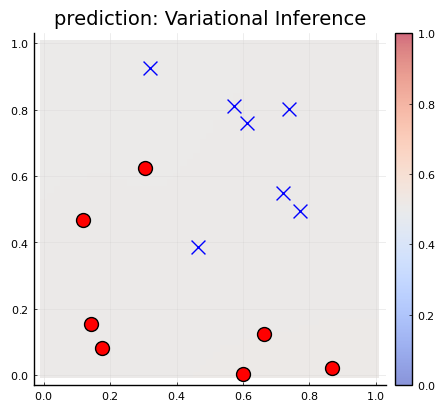

In [17]:
#initialize NN
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, st.Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 1e-3
model_params = (λw=λw, dw=dw, st=st)

#calculate the variational parameters
α = 0.3
tol = 1e-6
n_train = 3000
θvec, history = myVI(data, model_params, α, n_train, tol)

#posterior sample
n_samps = 5000
wsamps = rand(MvNormal(θvec[1:dw], exp.(θvec[dw+1:end])), n_samps)

#calculate and visualize predictive
fig8 = plot(0:0.02:1, 0:0.02:1, (x1,x2)->ppred([x1,x2], wsamps, st), st=:heatmap, c=cgrad(:coolwarm), alpha=0.6, clim=(0,1))
fig8 = plot_data(fig8, X, Y)
plot!(title="prediction: Variational Inference")
savefig(fig8, "figs-BNN/fig8.png")

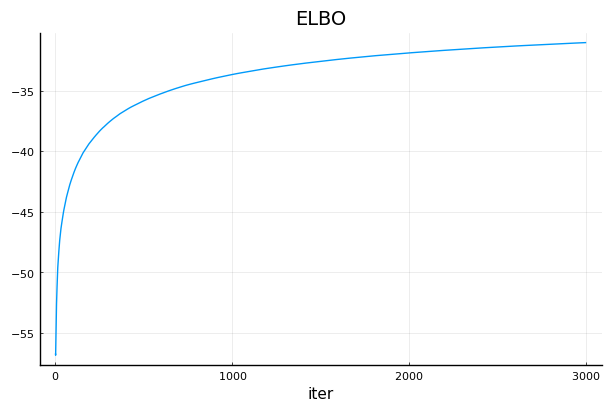

In [18]:
fig9 = plot(history, xlabel="iter", title="ELBO", label=false)
savefig(fig9, "figs-BNN/fig9.png")

## 3. compare VI approximated posterior to the true posterior

In [19]:
#posterior of w
function wpost(wsamps, θvec, nrow, ncol)
    plot_array = []
    p = plot(;)
    for j in 1:dw
        p = plot(wsamps[j,:], st=:histogram, label=false, normed=true)
        plot!(-100:1:100, x->pdf(Normal(θvec[j], exp(θvec[dw+j])),x), label=false, xlabel="w")
        push!(plot_array, p)
    end
    plot(plot_array..., layout=(nrow, ncol), size=(1000, 600))
end

wpost (generic function with 1 method)

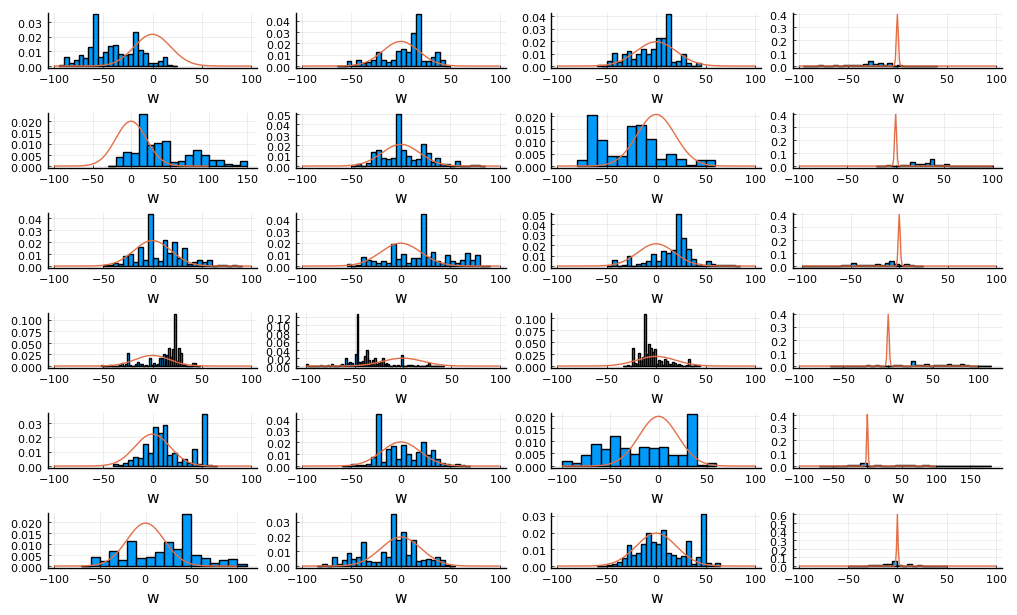

In [20]:
nrow = 6
ncol = 4
fig10 = wpost(w_post_samps, θvec, nrow, ncol)
savefig(fig10, "figs-BNN/fig10.png")